# Relationship between clinical scores and morphological caracteristics in Bipolar Disorder

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.robust.robust_linear_model import RLM

# Data load

Clinical data are loaded from the table updated on 2021-01-23. This table contains the phenotypic information and clinical scores for 104 patients.

Morphological data are loaded from the table 'group_stats.csv' generated by the script 'qc_complete.py'. This table contains the morphological features for 80 patients that had an MRI exam. Morphological features consist in cortical thickness extracted from the Freesurfer cortical parcelation, as well as volumes of cortical and subcortical structures. All volumes have been normalized by the ETIV (estimated total intracranial volume) of each patient.


In [2]:
clinical_data_path = r"P:\Adalab\Agence\Missions\MISSION_NemOmics-bipolar\base nemo maj 23.01.25 anonym.xlsx"
morpho_data_path = r"P:\Adalab\Agence\Missions\MISSION_NemOmics-bipolar\fsqc\group_stats.csv"
merged_data_path = r"P:\Adalab\Agence\Missions\MISSION_NemOmics-bipolar\fsqc\group_stats_with_clinical.csv"

In [3]:
clinical_data = pd.read_excel(clinical_data_path, sheet_name="DATABASE_ALL")
# Remove lines where Num is NaN or missing
clinical_data = clinical_data.dropna(subset=["Num"])
# Reformat "Num" column such that 1054-001 becomes sub-1054001
clinical_data["Num"] = clinical_data["Num"].apply(lambda x: "sub-" + x.replace("-", ""))
# Rename column to subject
clinical_data = clinical_data.rename(columns={"Num": "subject"})
clinical_data

subject  Unnamed: 1    Fondacode        GUID   BIOFACE  IRM  Age   \
0    sub-1054001         NaN  601773179.0  31D65B22F9  CE 08935  1.0  50.0   
1    sub-1054002         NaN  601650323.0  DE05609621         .  1.0  38.0   
2    sub-1054003         NaN  601613013.0  OF2B070662         .  1.0  44.0   
3    sub-1054004         NaN  601667540.0  B82BEBC033  CE 09883  1.0  23.0   
4    sub-1054005         NaN  601886300.0  506EEOBAB5         .  0.0  30.0   
..           ...         ...          ...         ...       ...  ...   ...   
98   sub-1054099         NaN  601900970.0  90652BD4A7       NaN  1.0  47.0   
99   sub-1054100         NaN  601446832.0  D46C858423       NaN  1.0  41.0   
100  sub-1054101         NaN  601800622.0  5F39F5C552       NaN  1.0  18.0   
101  sub-1054102         NaN  601167085.0  E6A784357A       NaN  1.0  38.0   
102  sub-1054103         NaN  601181222.0  9559716B82       NaN  1.0  54.0   

    Sexe  Age_Pere_birth  Age_mere_birth  ...  D_Nbr_RI      D_%RC      D_%RI  \
0      M             0.0             1.0  ...         .          .          .   
1      F             0.0             0.0  ...         .          .          .   
2      F             0.0             0.0  ...         8  77.777778  22.222222   
3      F             0.0             0.0  ...         .          .          .   
4      F             0.0             0.0  ...         .          .          .   
..   ...             ...             ...  ...       ...        ...        ...   
98     M             0.0             0.0  ...       NaN        NaN        NaN   
99     F             0.0             0.0  ...       NaN        NaN        NaN   
100    F             1.0             1.0  ...       NaN        NaN        NaN   
101    F             0.0             0.0  ...       NaN        NaN        NaN   
102    M             0.0             0.0  ...       NaN        NaN        NaN   

     D_Moy_TRT  D_Moy_TR_RC  D_Moy_TR_RI  TempsExpVsIRM  Cig_2h_avant  \
0            .            .            .              .             .   
1            .            .            .              .             .   
2         8959  7382.083333  6931.535714          Avant           OUI   
3            .            .            .              .             .   
4            .            .            .              .             .   
..         ...          ...          ...            ...           ...   
98         NaN          NaN          NaN            NaN           NaN   
99         NaN          NaN          NaN            NaN           NaN   
100        NaN          NaN          NaN            NaN           NaN   
101        NaN          NaN          NaN            NaN           NaN   
102        NaN          NaN          NaN            NaN           NaN   

     Cafe_2h_avant  GROUPE_TEST  
0                .            .  
1                .            .  
2              NON          NaN  
3                .          NaN  
4                .          NaN  
..             ...          ...  
98             NaN          NaN  
99             NaN          NaN  
100            NaN          NaN  
101            NaN          NaN  
102            NaN          NaN  

[103 rows x 391 columns]

In [4]:
morpho_data = pd.read_csv(morpho_data_path)
morpho_data

subject  aseg.BrainSeg  aseg.BrainSegNotVent  \
0   sub-1054001       0.744251              0.725919   
1   sub-1054002       0.715450              0.689616   
2   sub-1054003       0.782642              0.767972   
3   sub-1054004       0.751385              0.732505   
4   sub-1054010       0.744251              0.725919   
..          ...            ...                   ...   
75  sub-1054088       0.960811              0.950540   
76  sub-1054089       0.688792              0.671239   
77  sub-1054090       0.782657              0.777269   
78  sub-1054091       0.954806              0.942207   
79  sub-1054092       1.011041              0.996242   

    aseg.VentricleChoroidVol  aseg.lhCortex  aseg.rhCortex  aseg.Cortex  \
0                   0.015734       0.142865       0.142522     0.285387   
1                   0.022641       0.147196       0.143967     0.291162   
2                   0.011705       0.153757       0.154524     0.308281   
3                   0.015582       0.162390       0.163418     0.325809   
4                   0.015734       0.142865       0.142522     0.285387   
..                       ...            ...            ...          ...   
75                  0.007992       0.188811       0.188591     0.377402   
76                  0.014659       0.134259       0.131868     0.266127   
77                  0.003711       0.147229       0.148991     0.296219   
78                  0.009832       0.189352       0.187611     0.376963   
79                  0.011860       0.204037       0.201190     0.405227   

    aseg.lhCerebralWhiteMatter  aseg.rhCerebralWhiteMatter  \
0                     0.163602                    0.163613   
1                     0.135617                    0.130809   
2                     0.157546                    0.159457   
3                     0.140368                    0.140151   
4                     0.163602                    0.163613   
..                         ...                         ...   
75                    0.193487                    0.194852   
76                    0.146183                    0.144169   
77                    0.167712                    0.168384   
78                    0.208986                    0.208483   
79                    0.205233                    0.203893   

    aseg.CerebralWhiteMatter  ...  aparc.rh.rostralanteriorcingulate  \
0                   0.327215  ...                              2.697   
1                   0.266426  ...                              2.893   
2                   0.317004  ...                              2.905   
3                   0.280519  ...                              2.842   
4                   0.327215  ...                              2.697   
..                       ...  ...                                ...   
75                  0.388339  ...                              2.560   
76                  0.290352  ...                              2.551   
77                  0.336096  ...                              2.757   
78                  0.417470  ...                              2.864   
79                  0.409126  ...                              2.704   

    aparc.rh.rostralmiddlefrontal  aparc.rh.superiorfrontal  \
0                           2.398                     2.641   
1                           2.274                     2.649   
2                           2.326                     2.643   
3                           2.408                     2.767   
4                           2.398                     2.641   
..                            ...                       ...   
75                          2.320                     2.743   
76                          2.385                     2.655   
77                          2.504                     2.790   
78                          2.284                     2.875   
79                          2.153                     2.551   

    aparc.rh.superiorparietal  aparc.rh.superiortemporal  \
0      

### Data selection

Here we select only the columns of interest for the statistical analyses

In [5]:
# Columns of interest
morpho_columns = morpho_data.columns
morpho_variables = morpho_columns.difference(["subject"])
clinical_variables = ["Age ", "Sexe", "duree_evol", "NDP_load", "Score_Cluster_Neonat", "Score_Cluster_EarlyOnset", "Score_Cluster_Dvlpmt"]
clinical_data = clinical_data[["subject"] + clinical_variables]

In [6]:
# Merge the two dataframes on the subject column
merged_data = pd.merge(clinical_data, morpho_data, on="subject")
merged_data

subject  Age  Sexe  duree_evol  NDP_load  Score_Cluster_Neonat  \
0   sub-1054001  50.0    M        20.0  0.500000                   0.5   
1   sub-1054002  38.0    F        23.0  0.500000                   0.0   
2   sub-1054003  44.0    F        27.0  1.166667                   0.0   
3   sub-1054004  23.0    F        10.0  0.500000                   0.0   
4   sub-1054010  56.0    M        28.0  2.250000                   1.0   
..          ...   ...  ...         ...       ...                   ...   
75  sub-1054088  28.0    F        13.0  0.833333                   0.0   
76  sub-1054089  59.0    M        13.0  0.333333                   0.0   
77  sub-1054090  35.0    F        23.0  0.833333                   0.0   
78  sub-1054091  36.0    M        24.0  0.583333                   0.0   
79  sub-1054092  35.0    F        14.0  0.000000                   0.0   

    Score_Cluster_EarlyOnset  Score_Cluster_Dvlpmt  aseg.BrainSeg  \
0                       0.00              0.000000       0.744251   
1                       0.50              0.000000       0.715450   
2                       0.50              0.666667       0.782642   
3                       0.50              0.000000       0.751385   
4                       0.25              1.000000       0.744251   
..                       ...                   ...            ...   
75                      0.50              0.333333       0.960811   
76                      0.00              0.333333       0.688792   
77                      0.50              0.333333       0.782657   
78                      0.25              0.333333       0.954806   
79                      0.00              0.000000       1.011041   

    aseg.BrainSegNotVent  ...  aparc.rh.rostralanteriorcingulate  \
0               0.725919  ...                              2.697   
1               0.689616  ...                              2.893   
2               0.767972  ...                              2.905   
3               0.732505  ...                              2.842   
4               0.725919  ...                              2.697   
..                   ...  ...                                ...   
75              0.950540  ...                              2.560   
76              0.671239  ...                              2.551   
77              0.777269  ...                              2.757   
78              0.942207  ...                              2.864   
79              0.996242  ...                              2.704   

    aparc.rh.rostralmiddlefrontal  aparc.rh.superiorfrontal  \
0                           2.398                     2.641   
1                           2.274                     2.649   
2                           2.326                     2.643   
3                           2.408                     2.767   
4                           2.398                     2.641   
..                            ...                       ...   
75                          2.320                     2.743   
76                          2.385                     2.655   
77                          2.504                     2.790   
78                          2.284                     2.875   
79                          2.153                     2.551   

    aparc.rh.superiorparietal  aparc.rh.superiortemporal  \
0                       2.338                      2.770   
1                       2.468                      2.888   
2                       2.259                      2.909   
3                       2.491                      2.927   
4                       2.338                      2.770   
..                        ...                        ...   
75                      2.349                      3.078   
76                      2.243                      2.795   
77                      2.437                      2.944   
78                      2.423                      2.983   
79                      2.334                      2.944

In [7]:
# Save the merged dataframe
merged_data.to_csv(merged_data_path, index=False)

# Data exploration

Data exploration is usefull to varify statistical assumptions such as :
- Independence of observations
- Homogeneity of variance (for group analysis)
- Normality of quantitative data

This part includes the following steps :
1. A descriptive analysis of variables (means, medians, standard deviations, etc.)
2. A visualisation of variables distributions (hist, boxplots, etc.)
3. An analysis of the relationship between variables (correlation matrix, scatter plots)

### Descriptive analysis

In [23]:
# Descriptive statistics
descriptive_stats = merged_data.describe()
print(descriptive_stats)

            Age   duree_evol   NDP_load  Score_Cluster_Neonat  \
count  80.000000   80.000000  80.000000              80.00000   
mean   35.687500   16.675000   0.765625               0.10000   
std    12.355078   10.497468   0.521529               0.25656   
min    19.000000    2.000000   0.000000               0.00000   
25%    25.000000    8.000000   0.333333               0.00000   
50%    34.000000   15.000000   0.625000               0.00000   
75%    45.500000   24.500000   1.083333               0.00000   
max    59.000000   40.000000   2.250000               1.00000   

       Score_Cluster_EarlyOnset  Score_Cluster_Dvlpmt  aseg.BrainSeg  \
count                 80.000000             80.000000      80.000000   
mean                   0.365625              0.300000       0.809638   
std                    0.286687              0.302823       0.092262   
min                    0.000000              0.000000       0.678771   
25%                    0.250000              0.000000 

### Visualisation

Here we visualise the distribution of clinical variables in the sample.

We assume that morphological variables follow a normal distribution.
However, the clinical data does not follow a normal distribution.

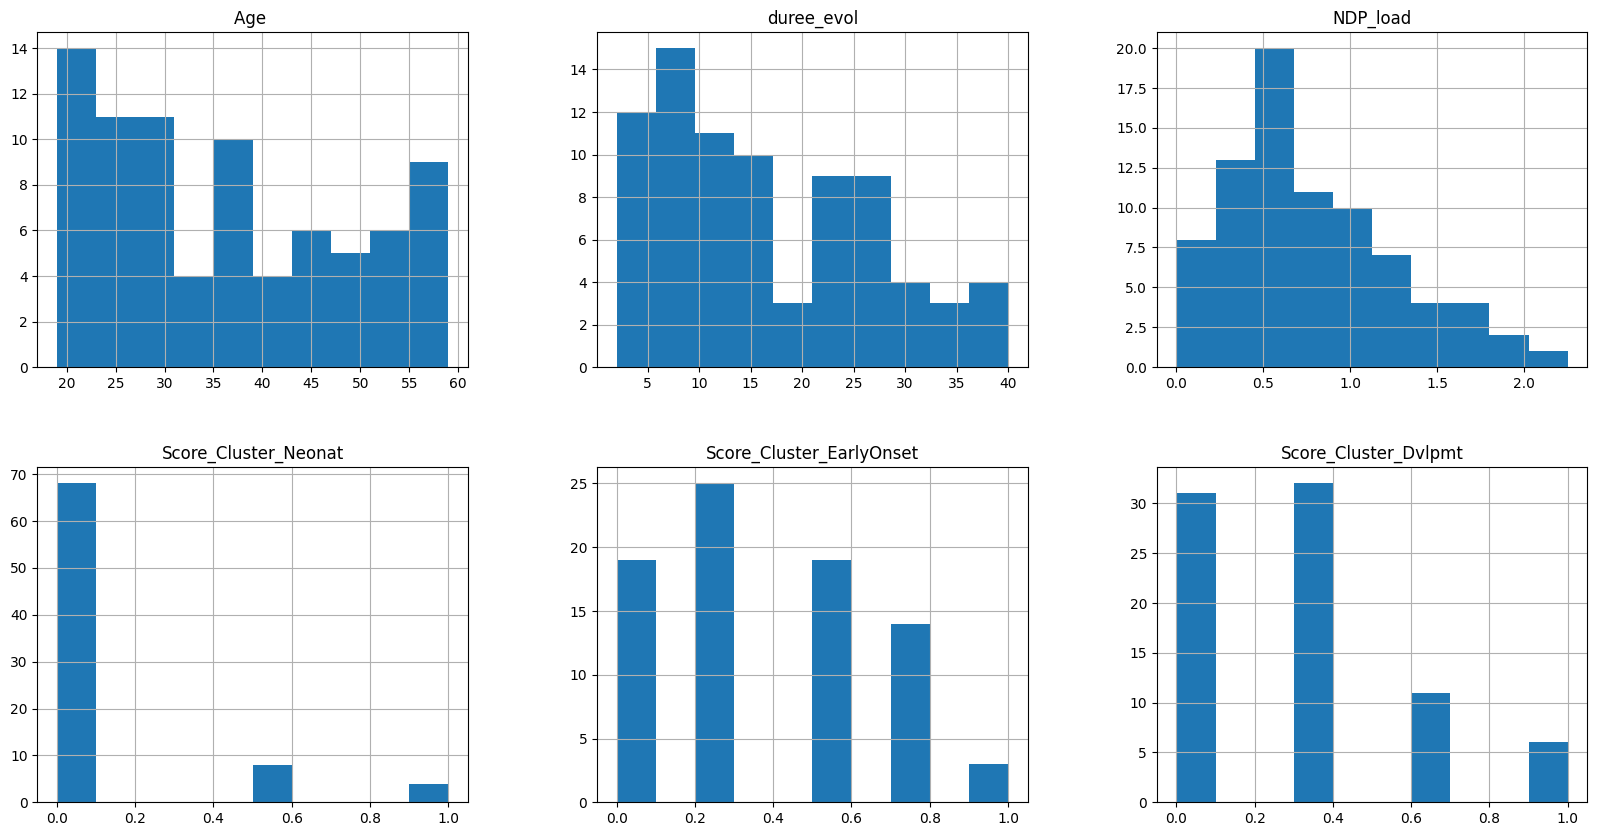

In [24]:
merged_data[clinical_variables].hist(figsize=(20, 10), layout=(2, 3))
plt.show()

C:\Users\lucil\AppData\Local\Temp\ipykernel_4824\1496037189.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data["Sexe"] = merged_data["Sexe"].replace({"F": 1, "M": 0})


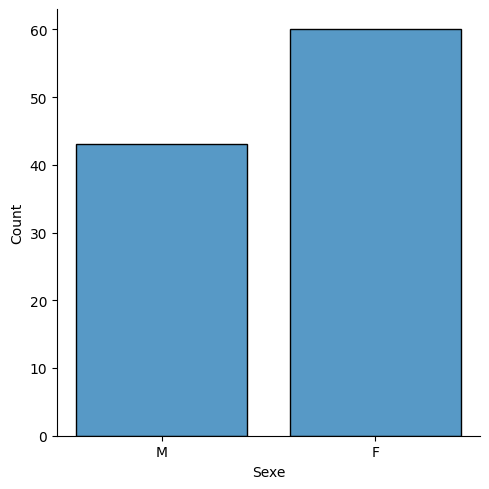

In [8]:
sns.displot(clinical_data["Sexe"], discrete=True, shrink=.8)
# replace 'F' by 1 and 'M' by 0
merged_data["Sexe"] = merged_data["Sexe"].replace({"F": 1, "M": 0})

### Correlation matrix

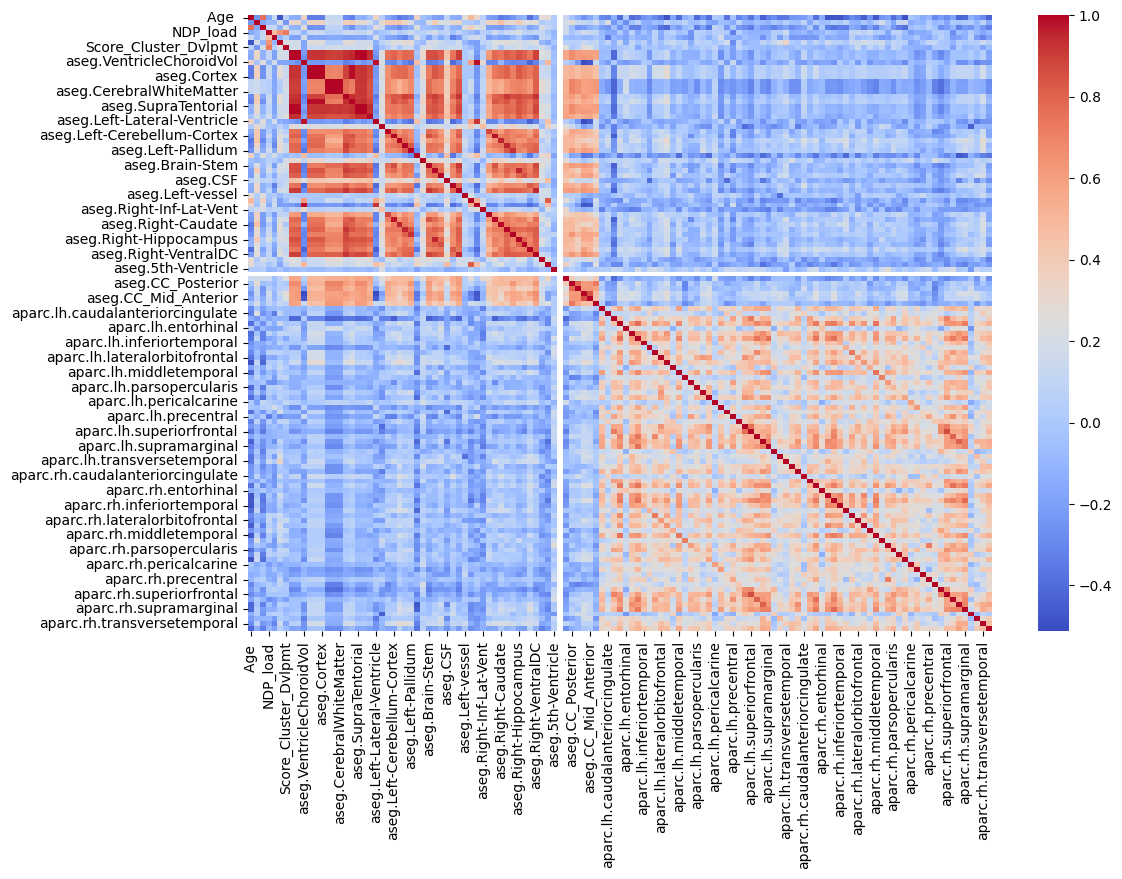

In [26]:
# Correlation matrix
data = merged_data.drop(columns=["subject"])
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

De manière attendue, on observe :
- un coefficient de corrélation important entre l'âge et la durée d'évolution de la maladie
- un coefficient de corrélation important entre le NDP_load et les sous-scores cliniques (ATTENTION la distribution de NDP load n'est pas normale !)

Les indices d'épaisseurs corticale sont très corrélés entre eux, de même que les volumes.

L'effet de l'âge n'apparait pas dans la matrice de corrélation, probablement dû au fait que le lien avec la morphométrie n'est pas linéaire.

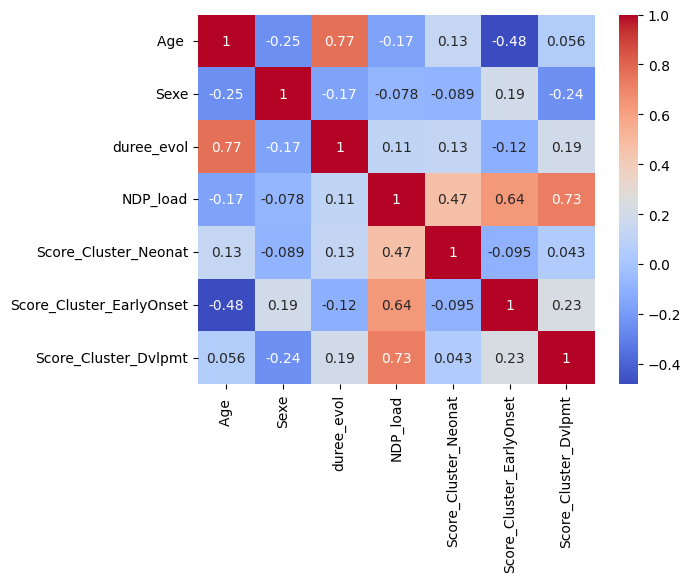

In [27]:
# Correlation matrix: zoom on clinical data
data = merged_data[clinical_variables]
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Data analysis

### Correlation between Age and Durée d'évolution

A significant linear relationship exists between age and duree_evol.
Almost 60% of the variance of duree_evol is explained by age. With a higher coefficient, it would have been relevant to ignore this covariate.

Other solutions allow managing this colinearity:
- Combine the covariates into a unique one (sum, mean)
- Use an ACP to reduce dimensionality and create uncorrelated independant variables (but also reducing the interpretability)
- Use the Ridge (or Lasso) Regression model which still takes into acount this covariate but with reduced impact of multicolinearity on the multiple regression model.


                            OLS Regression Results                            
Dep. Variable:             duree_evol   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     110.4
Date:                Mon, 03 Feb 2025   Prob (F-statistic):           1.34e-16
Time:                        16:06:06   Log-Likelihood:                -265.82
No. Observations:                  80   AIC:                             535.6
Df Residuals:                      78   BIC:                             540.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.5379      2.336     -2.799      0.0

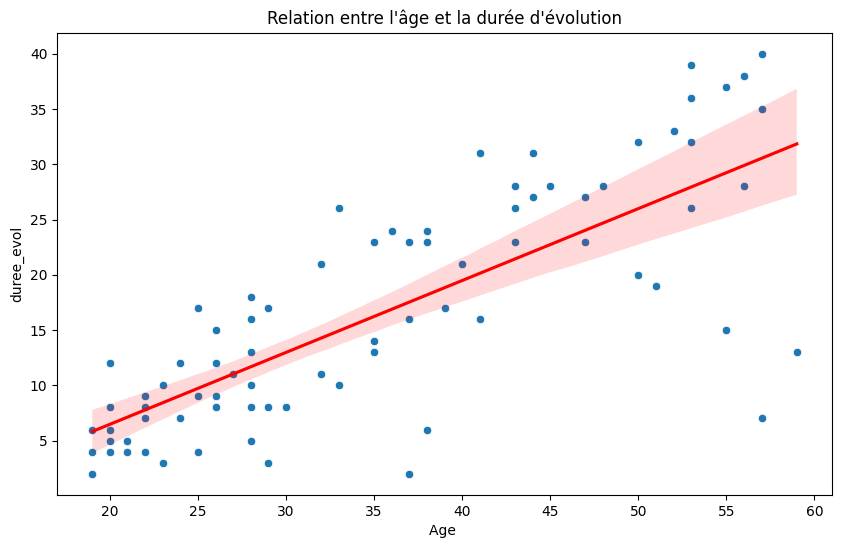

In [28]:
# Définir les variables indépendantes et dépendantes
X = merged_data['Age ']
y = merged_data['duree_evol']

# Ajouter une constante pour le terme d'interception
X = sm.add_constant(X)

# Ajuster le modèle de régression linéaire simple
model = sm.OLS(y, X).fit()

# Résumé des résultats
print(model.summary())

# Visualisation de la relation avec une ligne de régression
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age ', y='duree_evol', data=merged_data)
sns.regplot(x='Age ', y='duree_evol', data=merged_data, scatter=False, color='red')
plt.title('Relation entre l\'âge et la durée d\'évolution')
plt.show()

### Relationship between Age and Morphometry

Here we display the scatter plot with a polynomial curve (2nd order) to visualise the non-linear relationship between Age and Morphometry. This relationship will be tested below.

The translucid band corresponds to the size of the confidence interval for the regression estimate.

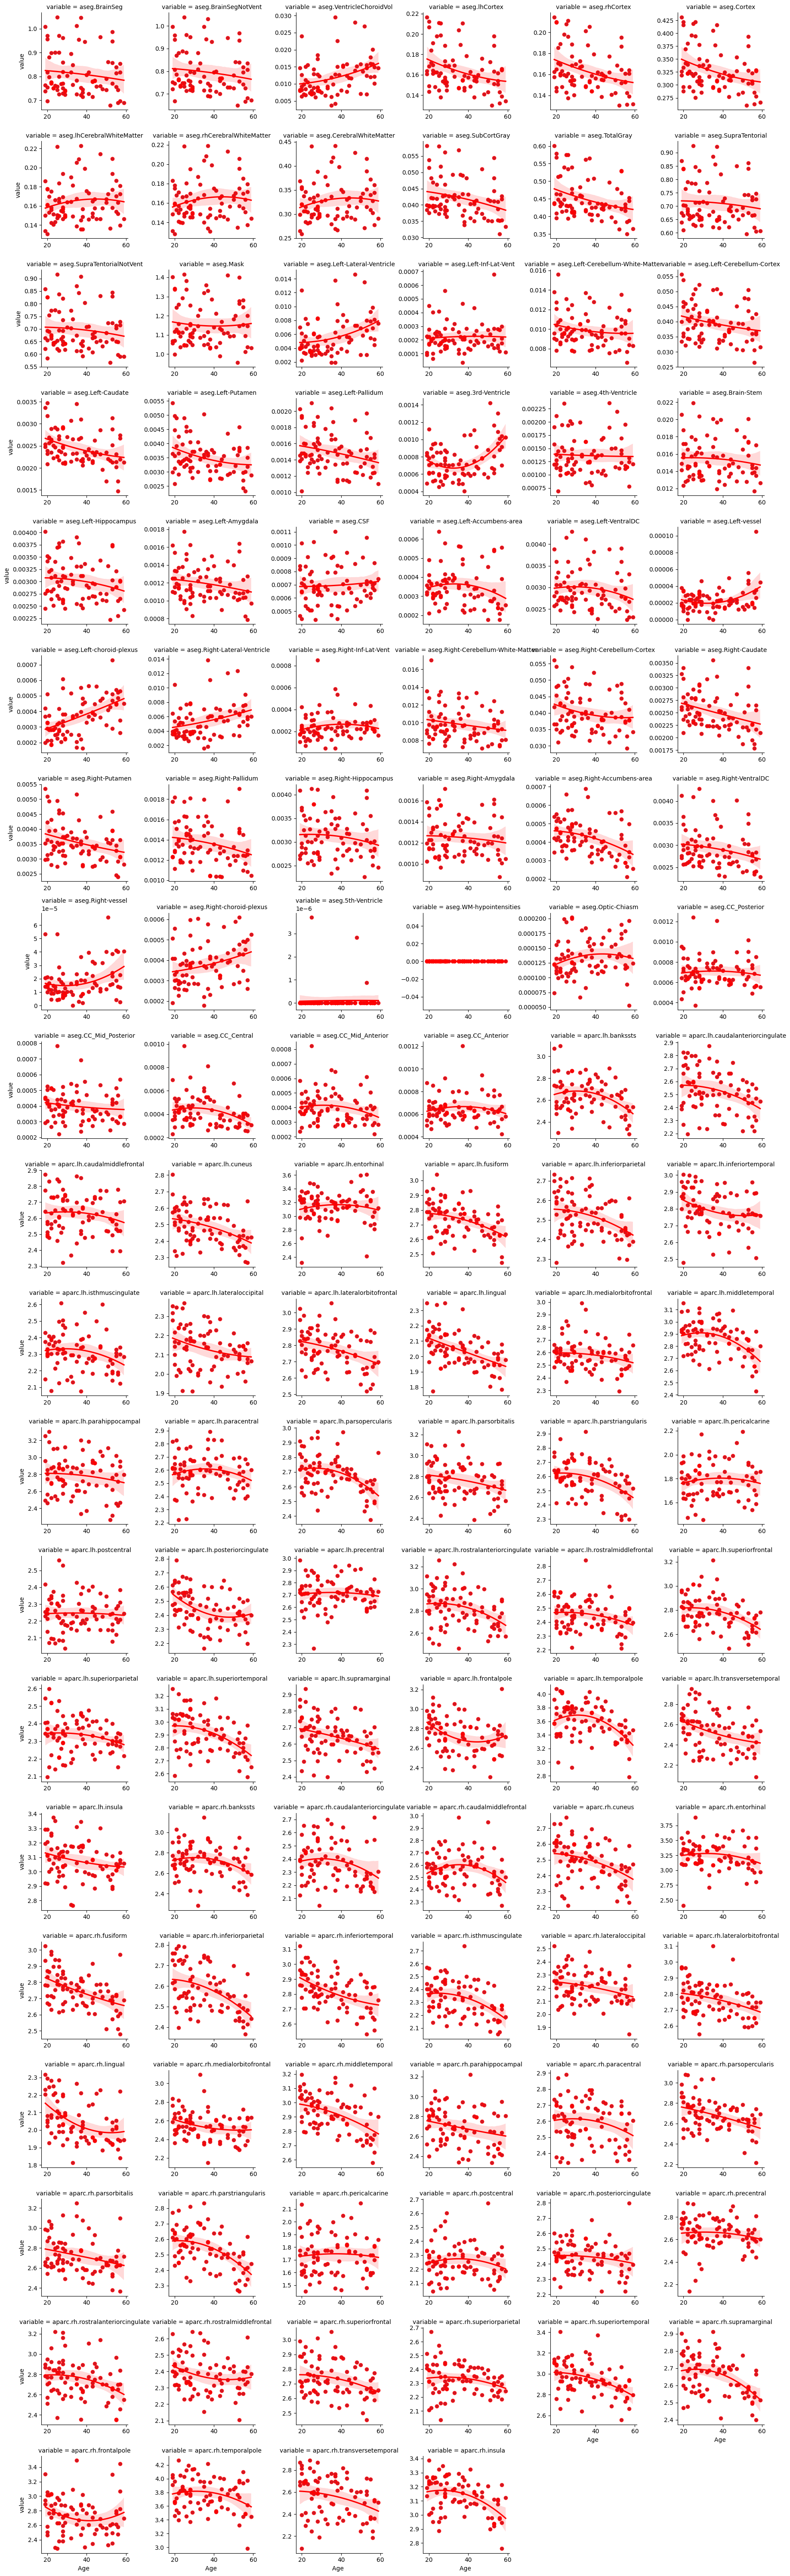

In [29]:
# Créer un tableau de vignettes pour visualiser la relation entre Age et les colonnes morphologiques
g = sns.FacetGrid(pd.melt(merged_data, id_vars=["subject", "Age "], value_vars=morpho_columns), col="variable", col_wrap=6, sharex=False, sharey=False)
g.map(sns.scatterplot, "Age ", "value")
g.map(sns.regplot, "Age ", "value", order=2, color='red')
plt.show()

A polynomial regression model is used to test the non-linear relationship between Age and the morphological variables.
For that purpose, a quadratic term is added for age : age ** 2

Results confirm the polynomial relationship with some of the morphometric indices.

In [30]:
# Création des termes polynomiaux
merged_data['age_squared'] = merged_data['Age '] ** 2

In [31]:
cortical_areas_with_significant_age_squared = {}

# Ajustement du modèle de régression polynomiale
X = merged_data[['Age ', 'age_squared']]
X = sm.add_constant(X)

for morpho in morpho_variables:
    y = merged_data[morpho]

    #model = sm.OLS(y, X).fit()
    # Ajuster le modèle de régression robuste
    model = RLM(y, X).fit()
    #print(model.summary())
    #print("\n\n")
    
    # Résumé des résultats
    summary = model.summary2().tables[1]  # Utiliser summary2 pour un accès plus facile aux tables

    # Filtrer les résultats pour NDP_load avec p-value < 0.05
    significant_effects = summary[(summary['P>|z|'] < 0.05) & (summary.index == 'age_squared')]

    # Afficher les résultats
    if not significant_effects.empty:
        cortical_areas_with_significant_age_squared[morpho] = significant_effects

c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\robust\robust_linear_model.py:167: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


In [32]:
#convert dict to dataframe
cortical_areas_with_significant_age_squared_df = pd.concat(cortical_areas_with_significant_age_squared)
cortical_areas_with_significant_age_squared_df

Coef.      Std.Err.  \
aparc.lh.bankssts            age_squared -3.160873e-04  1.384229e-04   
aparc.lh.middletemporal      age_squared -2.794591e-04  1.182926e-04   
aparc.lh.parsopercularis     age_squared -2.054671e-04  9.594795e-05   
aparc.lh.temporalpole        age_squared -5.646285e-04  2.021384e-04   
aparc.rh.caudalmiddlefrontal age_squared -2.524364e-04  1.285980e-04   
aseg.3rd-Ventricle           age_squared  5.441460e-07  1.595159e-07   
aseg.5th-Ventricle           age_squared  1.092587e-66  2.065789e-67   

                                                 z         P>|z|  \
aparc.lh.bankssts            age_squared -2.283491  2.240148e-02   
aparc.lh.middletemporal      age_squared -2.362440  1.815509e-02   
aparc.lh.parsopercularis     age_squared -2.141444  3.223826e-02   
aparc.lh.temporalpole        age_squared -2.793277  5.217695e-03   
aparc.rh.caudalmiddlefrontal age_squared -1.962989  4.964740e-02   
aseg.3rd-Ventricle           age_squared  3.411233  6.466982e-04   
aseg.5th-Ventricle           age_squared  5.288956  1.230163e-07   

                                                [0.025        0.975]  
aparc.lh.bankssts            age_squared -5.873911e-04 -4.478350e-05  
aparc.lh.middletemporal      age_squared -5.113082e-04 -4.760991e-05  
aparc.lh.parsopercularis     age_squared -3.935217e-04 -1.741263e-05  
aparc.lh.temporalpole        age_squared -9.608125e-04 -1.684446e-04  
aparc.rh.caudalmiddlefrontal age_squared -5.044838e-04 -3.890717e-07  
aseg.3rd-Ventricle           age_squared  2.315005e-07  8.567914e-07  
aseg.5th-Ventricle           age_squared  6.876994e-67  1.497474e-66

### Relationship between NDP load and Morphometry 

Now, to test this relationship we will use 3 different methods:
- Multiple linear regression (assumes normal distribution of variables)
- Robust regression model (robust to outliers)
- Non parametric model

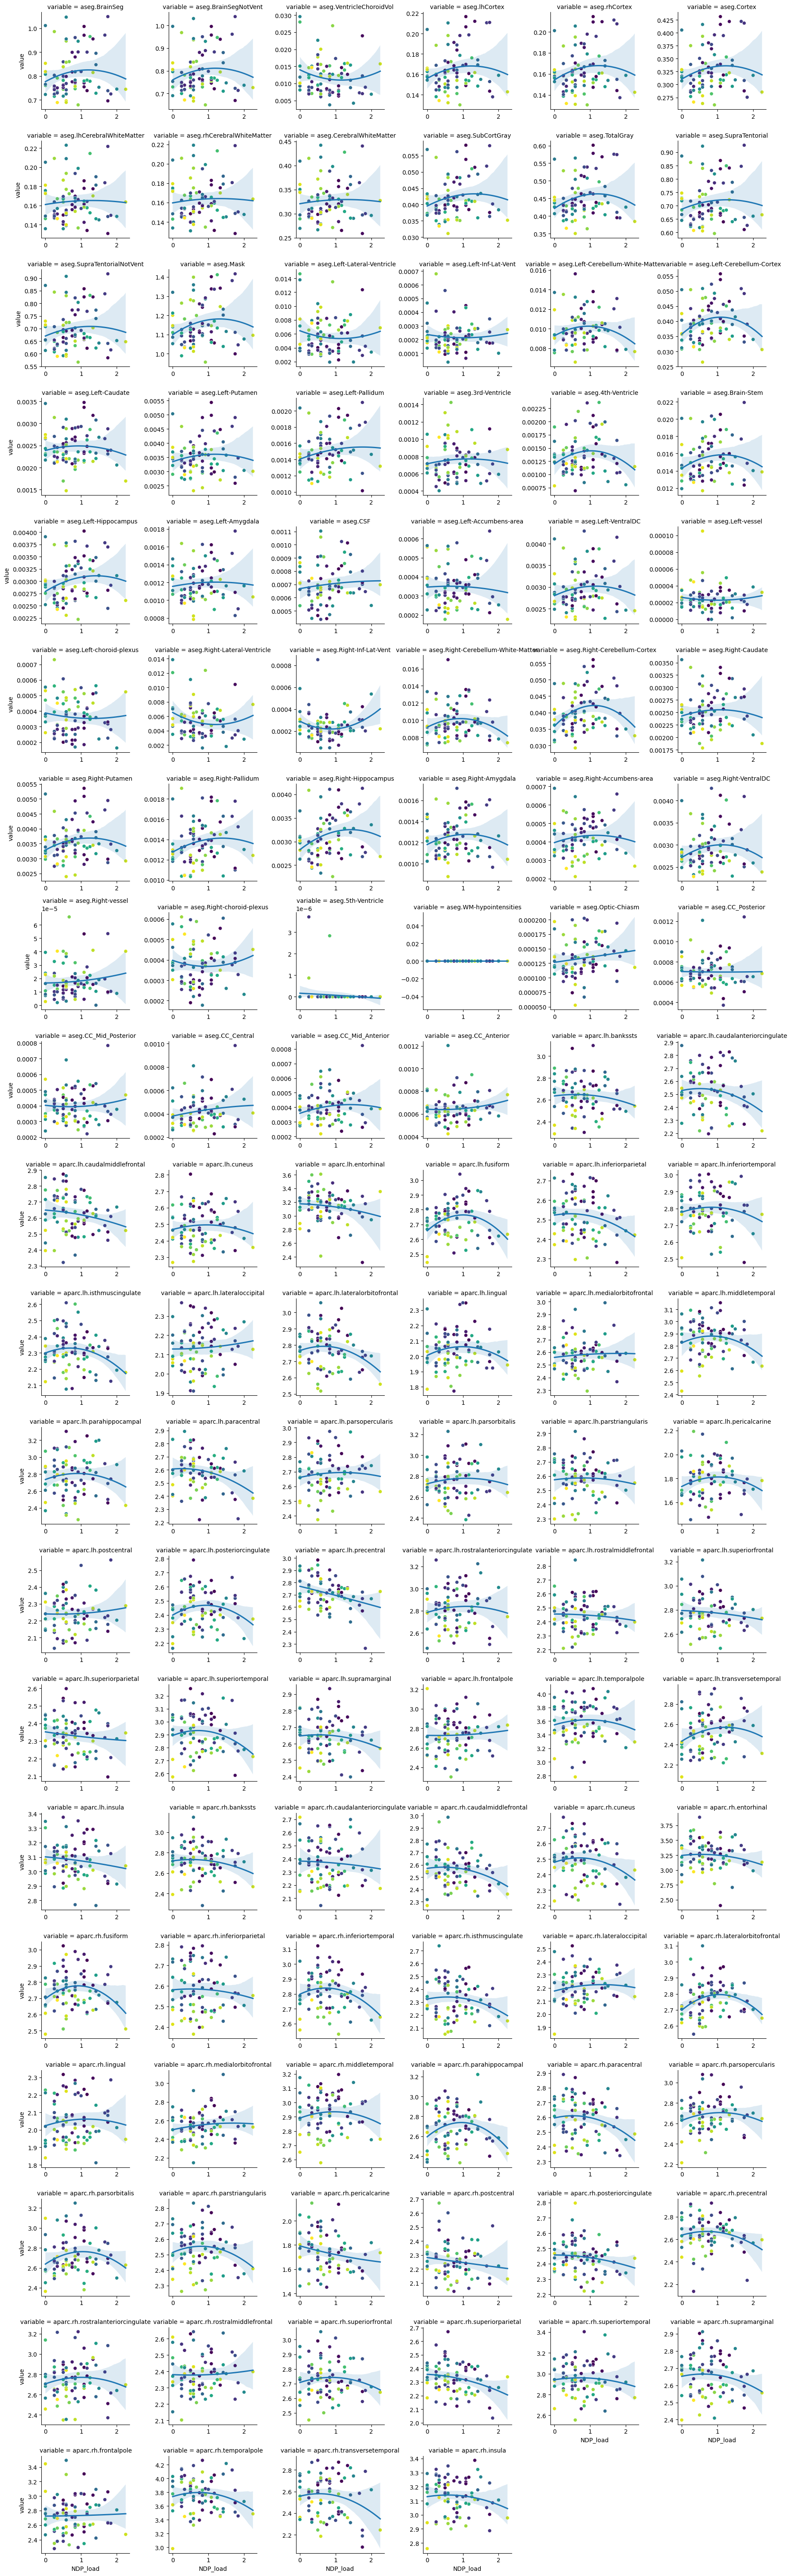

In [33]:
# Créer un tableau de vignettes pour visualiser la relation entre Age et les colonnes morphologiques
g = sns.FacetGrid(pd.melt(merged_data, id_vars=["subject", "NDP_load", "Age "], value_vars=morpho_columns), col="variable", col_wrap=6, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="NDP_load", y="value", hue="Age ", palette="viridis", legend=False)
g.map_dataframe(sns.regplot, "NDP_load", "value", order=2, scatter=False)

plt.show()

**Analyse de régression multiple :**

Utilisez une régression linéaire multiple pour modéliser la relation entre le score clinique (variable indépendante) et les indices morphométriques (variables dépendantes), en incluant l'âge, le sexe et la durée de la pathologie comme covariables.

In [34]:
cortical_areas_with_significant_NDP_load = {}

# Définir les variables indépendantes et dépendantes
X = merged_data[['Age ', 'age_squared', 'Sexe', 'duree_evol', 'NDP_load']]
# Ajouter une constante pour le terme d'interception
X = sm.add_constant(X)

for morpho in morpho_variables:
    y = merged_data[morpho]

    model = sm.OLS(y, X).fit()
    #print(model.summary())
    #print("\n\n")

    # Résumé des résultats
    summary = model.summary2().tables[1]  # Utiliser summary2 pour un accès plus facile aux tables

    # Filtrer les résultats pour NDP_load avec p-value < 0.05
    significant_effects = summary[(summary['P>|t|'] < 0.05) & (summary.index == 'NDP_load')]

    # Afficher les résultats
    if not significant_effects.empty:
        cortical_areas_with_significant_NDP_load[morpho] = significant_effects


c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\regression\linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid


In [96]:
#convert dict to dataframe
cortical_areas_with_significant_NDP_load_df = pd.concat(cortical_areas_with_significant_NDP_load)
cortical_areas_with_significant_NDP_load_df

Coef.  Std.Err.         t     P>|t|  \
aparc.lh.caudalmiddlefrontal NDP_load -0.073452  0.027442 -2.676647  0.009153   
aparc.lh.inferiorparietal    NDP_load -0.048315  0.024182 -1.997938  0.049399   
aparc.lh.paracentral         NDP_load -0.086084  0.031226 -2.756824  0.007346   
aparc.lh.precentral          NDP_load -0.105871  0.026812 -3.948641  0.000178   
aparc.lh.superiortemporal    NDP_load -0.090386  0.030833 -2.931449  0.004486   
aparc.rh.caudalmiddlefrontal NDP_load -0.080711  0.030766 -2.623398  0.010567   
aparc.rh.entorhinal          NDP_load -0.110979  0.054739 -2.027435  0.046220   
aparc.rh.inferiortemporal    NDP_load -0.079986  0.024190 -3.306557  0.001459   
aparc.rh.insula              NDP_load -0.052488  0.025703 -2.042112  0.044704   
aparc.rh.paracentral         NDP_load -0.082148  0.030475 -2.695621  0.008692   
aparc.rh.posteriorcingulate  NDP_load -0.060422  0.024173 -2.499578  0.014651   
aparc.rh.precentral          NDP_load -0.069481  0.033332 -2.084529  0.040563   
aparc.rh.superiorparietal    NDP_load -0.084410  0.025173 -3.353249  0.001261   
aparc.rh.supramarginal       NDP_load -0.062196  0.024725 -2.515552  0.014054   
aparc.rh.transversetemporal  NDP_load -0.090076  0.044392 -2.029092  0.046046   
aseg.Left-Hippocampus        NDP_load  0.000188  0.000091  2.073421  0.041614   
aseg.Right-Hippocampus       NDP_load  0.000218  0.000098  2.213336  0.029957   

                                         [0.025    0.975]  
aparc.lh.caudalmiddlefrontal NDP_load -0.128131 -0.018773  
aparc.lh.inferiorparietal    NDP_load -0.096500 -0.000130  
aparc.lh.paracentral         NDP_load -0.148303 -0.023865  
aparc.lh.precentral          NDP_load -0.159295 -0.052447  
aparc.lh.superiortemporal    NDP_load -0.151822 -0.028949  
aparc.rh.caudalmiddlefrontal NDP_load -0.142013 -0.019409  
aparc.rh.entorhinal          NDP_load -0.220048 -0.001910  
aparc.rh.inferiortemporal    NDP_load -0.128186 -0.031786  
aparc.rh.insula              NDP_load -0.103701 -0.001274  
aparc.rh.paracentral         NDP_load -0.142871 -0.021426  
aparc.rh.posteriorcingulate  NDP_load -0.108588 -0.012257  
aparc.rh.precentral          NDP_load -0.135896 -0.003066  
aparc.rh.superiorparietal    NDP_load -0.134567 -0.034252  
aparc.rh.supramarginal       NDP_load -0.111461 -0.012931  
aparc.rh.transversetemporal  NDP_load -0.178530 -0.001622  
aseg.Left-Hippocampus        NDP_load  0.000007  0.000369  
aseg.Right-Hippocampus       NDP_load  0.000022  0.000413

**Use robust regression model**:

Which is less sensitive to violations of the assumptions of normality and homoscedasticity

In [97]:
cortical_areas_with_significant_NDP_load = {}

# Définir les variables indépendantes et dépendantes
X = merged_data[['Age ', 'age_squared', 'Sexe', 'duree_evol', 'NDP_load']]
# Ajouter une constante pour le terme d'interception
X = sm.add_constant(X)

for morpho in morpho_variables:
    y = merged_data[morpho]

    model = RLM(y, X).fit()
    #print(model.summary())
    #print("\n\n")

    # Résumé des résultats
    summary = model.summary2().tables[1]  # Utiliser summary2 pour un accès plus facile aux tables

    # Filtrer les résultats pour NDP_load avec p-value < 0.05
    significant_effects = summary[(summary['P>|z|'] < 0.05) & (summary.index == 'NDP_load')]

    # Afficher les résultats
    if not significant_effects.empty:
        cortical_areas_with_significant_NDP_load[morpho] = significant_effects
        #print("Variable dépendante avec effet significatif de NDP_load:")
        #print(significant_effects)


c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\robust\robust_linear_model.py:167: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


In [98]:
#convert dict to dataframe
cortical_areas_with_significant_NDP_load_df = pd.concat(cortical_areas_with_significant_NDP_load)
cortical_areas_with_significant_NDP_load_df

Coef.      Std.Err.         z  \
aparc.lh.caudalmiddlefrontal NDP_load -7.767228e-02  2.907588e-02 -2.671365   
aparc.lh.paracentral         NDP_load -8.525742e-02  3.028787e-02 -2.814903   
aparc.lh.precentral          NDP_load -8.752930e-02  2.668600e-02 -3.279971   
aparc.lh.superiortemporal    NDP_load -1.007414e-01  2.988044e-02 -3.371483   
aparc.rh.caudalmiddlefrontal NDP_load -7.989591e-02  3.178726e-02 -2.513457   
aparc.rh.inferiortemporal    NDP_load -7.685625e-02  2.553155e-02 -3.010246   
aparc.rh.insula              NDP_load -5.425631e-02  2.601663e-02 -2.085448   
aparc.rh.paracentral         NDP_load -8.516701e-02  3.210220e-02 -2.652996   
aparc.rh.pericalcarine       NDP_load -7.836925e-02  3.809967e-02 -2.056954   
aparc.rh.postcentral         NDP_load -5.934631e-02  2.525475e-02 -2.349906   
aparc.rh.posteriorcingulate  NDP_load -5.274515e-02  2.267206e-02 -2.326438   
aparc.rh.precentral          NDP_load -7.598309e-02  2.836318e-02 -2.678934   
aparc.rh.superiorparietal    NDP_load -7.913932e-02  2.478064e-02 -3.193594   
aparc.rh.supramarginal       NDP_load -6.309359e-02  2.618770e-02 -2.409283   
aparc.rh.temporalpole        NDP_load -1.198070e-01  5.804176e-02 -2.064153   
aseg.5th-Ventricle           NDP_load -7.796384e-57  1.794408e-57 -4.344823   
aseg.Left-Hippocampus        NDP_load  2.354124e-04  8.293216e-05  2.838614   
aseg.Optic-Chiasm            NDP_load  1.478781e-05  6.991262e-06  2.115184   
aseg.Right-Hippocampus       NDP_load  2.377361e-04  9.536984e-05  2.492781   

                                          P>|z|        [0.025        0.975]  
aparc.lh.caudalmiddlefrontal NDP_load  0.007554 -1.346599e-01 -2.068461e-02  
aparc.lh.paracentral         NDP_load  0.004879 -1.446206e-01 -2.589429e-02  
aparc.lh.precentral          NDP_load  0.001038 -1.398329e-01 -3.522571e-02  
aparc.lh.superiortemporal    NDP_load  0.000748 -1.593060e-01 -4.217680e-02  
aparc.rh.caudalmiddlefrontal NDP_load  0.011955 -1.421978e-01 -1.759402e-02  
aparc.rh.inferiortemporal    NDP_load  0.002610 -1.268972e-01 -2.681533e-02  
aparc.rh.insula              NDP_load  0.037029 -1.052480e-01 -3.264663e-03  
aparc.rh.paracentral         NDP_load  0.007978 -1.480862e-01 -2.224785e-02  
aparc.rh.pericalcarine       NDP_load  0.039691 -1.530432e-01 -3.695276e-03  
aparc.rh.postcentral         NDP_load  0.018778 -1.088447e-01 -9.847898e-03  
aparc.rh.posteriorcingulate  NDP_load  0.019995 -9.718157e-02 -8.308726e-03  
aparc.rh.precentral          NDP_load  0.007386 -1.315739e-01 -2.039228e-02  
aparc.rh.superiorparietal    NDP_load  0.001405 -1.277085e-01 -3.057015e-02  
aparc.rh.supramarginal       NDP_load  0.015984 -1.144205e-01 -1.176663e-02  
aparc.rh.temporalpole        NDP_load  0.039003 -2.335668e-01 -6.047288e-03  
aseg.5th-Ventricle           NDP_load  0.000014 -1.131336e-56 -4.279410e-57  
aseg.Left-Hippocampus        NDP_load  0.004531  7.286832e-05  3.979564e-04  
aseg.Optic-Chiasm            NDP_load  0.034414  1.085184e-06  2.849043e-05  
aseg.Right-Hippocampus       NDP_load  0.012675  5.081465e-05  4.246576e-04

**Use non-parametric tests**

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [99]:

# Définir les variables indépendantes et dépendantes
X = merged_data[['Age ', 'age_squared', 'Sexe', 'duree_evol', 'NDP_load']]

# Standardiser les variables indépendantes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for morpho in morpho_variables:
    y = merged_data[morpho]

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Ajuster le modèle de régression non paramétrique (Random Forest)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Prédire sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Évaluer le modèle
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    if r2>0.1:
        
        print(f"Variable dépendante: {morpho}")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared: {r2}")

        # Importance des variables
        importances = model.feature_importances_
        feature_names = X.columns
        feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

        # Afficher l'importance des variables
        print(feature_importances)

        # Visualiser l'importance des variables
        # plt.figure(figsize=(10, 6))
        # plt.barh(feature_importances['Feature'], feature_importances['Importance'])
        # plt.xlabel('Importance')
        # plt.ylabel('Feature')
        # plt.title('Importance des Variables')
        # plt.gca().invert_yaxis()
        # plt.show()

        print("\n\n")


Variable dépendante: aparc.lh.middletemporal
Mean Squared Error: 0.029801414624999883
R-squared: 0.15787326024607506
       Feature  Importance
3   duree_evol    0.295706
4     NDP_load    0.223906
1  age_squared    0.217791
0         Age     0.214580
2         Sexe    0.048017



Variable dépendante: aparc.lh.parstriangularis
Mean Squared Error: 0.0073069683062500675
R-squared: 0.2891956942504317
       Feature  Importance
3   duree_evol    0.294191
0         Age     0.209735
4     NDP_load    0.206359
1  age_squared    0.198288
2         Sexe    0.091427



Variable dépendante: aparc.rh.isthmuscingulate
Mean Squared Error: 0.014654433206250067
R-squared: 0.16404863184009932
       Feature  Importance
3   duree_evol    0.350168
1  age_squared    0.220499
4     NDP_load    0.195760
0         Age     0.193025
2         Sexe    0.040549



Variable dépendante: aparc.rh.parsopercularis
Mean Squared Error: 0.03195831058749999
R-squared: 0.13324139797978463
       Feature  Importance
3   du

### Relationship between Neonat score and Morphometry 

Now, to test this relationship we will use :
- Robust regression model

In [36]:
cortical_areas_with_significant_Score_Neonat = {}

# Définir les variables indépendantes et dépendantes
X = merged_data[['Age ', 'age_squared', 'Sexe', 'duree_evol', 'Score_Cluster_Neonat']]
# Ajouter une constante pour le terme d'interception
X = sm.add_constant(X)

for morpho in morpho_variables:
    y = merged_data[morpho]

    model = RLM(y, X).fit()
    #print(model.summary())
    #print("\n\n")

    # Résumé des résultats
    summary = model.summary2().tables[1]  # Utiliser summary2 pour un accès plus facile aux tables

    # Filtrer les résultats pour NDP_load avec p-value < 0.05
    significant_effects = summary[(summary['P>|z|'] < 0.05) & (summary.index == 'NDP_load')]

    # Afficher les résultats
    if not significant_effects.empty:
        cortical_areas_with_significant_Score_Neonat[morpho] = significant_effects
        #print("Variable dépendante avec effet significatif de NDP_load:")
        #print(significant_effects)


c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\robust\robust_linear_model.py:167: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


In [42]:
cortical_areas_with_significant_Score_Neonat

{}

### Relationship between EarlyOnset score and Morphometry 

Now, to test this relationship we will use :
- Robust regression model

In [40]:
cortical_areas_with_significant_Score_EarlyOnset = {}

# Définir les variables indépendantes et dépendantes
X = merged_data[['Age ', 'age_squared', 'Sexe', 'duree_evol', 'Score_Cluster_EarlyOnset']]
# Ajouter une constante pour le terme d'interception
X = sm.add_constant(X)

for morpho in morpho_variables:
    y = merged_data[morpho]

    model = RLM(y, X).fit()
    #print(model.summary())
    #print("\n\n")

    # Résumé des résultats
    summary = model.summary2().tables[1]  # Utiliser summary2 pour un accès plus facile aux tables

    # Filtrer les résultats pour NDP_load avec p-value < 0.05
    significant_effects = summary[(summary['P>|z|'] < 0.05) & (summary.index == 'NDP_load')]

    # Afficher les résultats
    if not significant_effects.empty:
        cortical_areas_with_significant_Score_EarlyOnset[morpho] = significant_effects
        #print("Variable dépendante avec effet significatif de NDP_load:")
        #print(significant_effects)


c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\robust\robust_linear_model.py:167: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


In [41]:
cortical_areas_with_significant_Score_EarlyOnset

{}

### Relationship between Development score and Morphometry 

Now, to test this relationship we will use :
- Robust regression model

In [43]:
cortical_areas_with_significant_Score_Dvlpmt = {}

# Définir les variables indépendantes et dépendantes
X = merged_data[['Age ', 'age_squared', 'Sexe', 'duree_evol', 'Score_Cluster_Dvlpmt']]
# Ajouter une constante pour le terme d'interception
X = sm.add_constant(X)

for morpho in morpho_variables:
    y = merged_data[morpho]

    model = RLM(y, X).fit()
    #print(model.summary())
    #print("\n\n")

    # Résumé des résultats
    summary = model.summary2().tables[1]  # Utiliser summary2 pour un accès plus facile aux tables

    # Filtrer les résultats pour NDP_load avec p-value < 0.05
    significant_effects = summary[(summary['P>|z|'] < 0.05) & (summary.index == 'NDP_load')]

    # Afficher les résultats
    if not significant_effects.empty:
        cortical_areas_with_significant_Score_Dvlpmt[morpho] = significant_effects
        #print("Variable dépendante avec effet significatif de NDP_load:")
        #print(significant_effects)


c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\robust\robust_linear_model.py:167: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
c:\miniconda3\envs\nemo\Lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


In [44]:
cortical_areas_with_significant_Score_Dvlpmt

{}